<a href="https://colab.research.google.com/github/muhammadbabarkamal/AffectNet/blob/main/Xceptionnet_AND_MobileNet_V3_Affect_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Four Steps for Facial Expression recognition, and computing Valence and
Arousal

1.   Data Prepration
2.   Build the model
3.   Training the model
4.   Analyse the models results




In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Imports and Installation

In [8]:
import skimage.io as io
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
from IPython.core.display import HTML
from torch.utils.data import Dataset, DataLoader
import cv2
import glob
import numpy
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import cv2
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception 
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
!pip install tensorflow-addons
!pip install tensorflow-Ranking
import tensorflow_ranking as tfr
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
plt.style.use('fivethirtyeight')
toy=False

#Data Prepration

In [9]:
 train_dataset_path ='/content/gdrive/MyDrive/Colab Notebooks/face/new img'
 test_dataset_path='/content/gdrive/MyDrive/Colab Notebooks/face/test_set.tar (Unzipped Files)/val_set/images'
 labels_path ='/content/gdrive/MyDrive/Colab Notebooks/face/annota'
test_labels_path='/content/gdrive/MyDrive/Colab Notebooks/face/test_set.tar (Unzipped Files)/val_set/annotations'

### TRAIN DATA TO DATAFRAME

In [ ]:
from functools import reduce
Ind=[]
i=0
for dirname, _, filenames in os.walk(train_dataset_path):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        Ind.insert(1,os.path.join(dirname, filename))
        i=i+1
Image={"Image":Ind}
dfx = pd.DataFrame(Image) 
Val=[]
Exp=[]
Aro=[]
LM=[]
for cls_pth in glob.glob(labels_path+'/*'):
    a=cls_pth
    if (a.split('/')[-1]).endswith('_val.npy'):
      b=np.load(a)
      b=np.asarray(b).astype(np.float32) 
      Val.append(b)
    elif(a.split('/')[-1]).endswith('_exp.npy'):
      ex=np.load(a)
      ex=np.asarray(ex).astype(np.float32)
      Exp.append(ex)
    elif(a.split('/')[-1]).endswith('_aro.npy'):
      ar=np.load(a)
      ar=np.asarray(ar).astype(np.float32)
      Aro.append(ar)
    elif(a.split('/')[-1]).endswith('_lnd.npy'):
      lam=ar=np.load(a)
      lam=np.reshape(lam, (68,2), order='C')
      lam=np.asarray(lam).astype(np.float32)
      LM.append(lam)
    i=i+1
print(Val[0])
print(Exp[0])
print(Aro[0])
print(LM[0])
label1={"Expression":Exp}
label2={"Valance":Val}
label3={"Arosual":Aro}
Landmark={"Landmarks":LM}
dflm= pd.DataFrame(Landmark) 
dfy1 = pd.DataFrame(label1) 
dfy1['Expression'] = dfy1['Expression'].astype(float, errors = 'raise')
dfy2 = pd.DataFrame(label2)
dfy2['Valance'] = dfy2['Valance'].astype(float, errors = 'raise')
dfy3 = pd.DataFrame(label3)
dfy3['Arosual'] = dfy3['Arosual'].astype(float, errors = 'raise')
dfall= pd.concat([dfx,dflm, dfy1,dfy2,dfy3], axis=1)
dfall.to_csv('file1.csv')
dfall

###TEST DATA TO DATAFRAME

In [ ]:
from functools import reduce
Ind=[]
i=0
for dirname, _, filenames in os.walk(test_dataset_path):
    for filename in filenames:
        Ind.insert(1,os.path.join(dirname, filename))
        i=i+1
        if i>=884:
          break
Image={"Image":Ind}
dfxt = pd.DataFrame(Image) 
Val=[]
Exp=[]
Aro=[]
LM=[]
for cls_pth in glob.glob(test_labels_path+'/*'):
    a=cls_pth
    if (a.split('/')[-1]).endswith('_val.npy'):
      b=np.load(a)
      b=np.asarray(b).astype(np.float32) 
      Val.append(b)
    elif(a.split('/')[-1]).endswith('_exp.npy'):
      ex=np.load(a)
      ex=np.asarray(ex).astype(np.float32)
      Exp.append(ex)
    elif(a.split('/')[-1]).endswith('_aro.npy'):
      ar=np.load(a)
      ar=np.asarray(ar).astype(np.float32)
      Aro.append(ar)
    elif(a.split('/')[-1]).endswith('_lnd.npy'):
      lam=ar=np.load(a)
      lam=np.reshape(lam, (68,2), order='C')
      lam=np.asarray(lam).astype(np.float32)
      LM.append(lam)
    i=i+1
print(Val[0])
print(Exp[0])
print(Aro[0])
print(LM[0])
label1={"Expression":Exp}
label2={"Valance":Val}
label3={"Arosual":Aro}
Landmark={"Landmarks":LM}
dflmt= pd.DataFrame(Landmark) 
dfy1t = pd.DataFrame(label1) 
dfy1t['Expression'] = dfy1t['Expression'].astype(float, errors = 'raise')
dfy2t = pd.DataFrame(label2)
dfy2t['Valance'] = dfy2t['Valance'].astype(float, errors = 'raise')
dfy3t = pd.DataFrame(label3)
dfy3t['Arosual'] = dfy3t['Arosual'].astype(float, errors = 'raise')
dfallt= pd.concat([dfxt,dflmt, dfy1t,dfy2t,dfy3t], axis=1)
dfallt.to_csv('file1.csv')
dfallt

In [7]:
dfallT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image       3999 non-null   object 
 1   Landmarks   3999 non-null   object 
 2   Expression  3999 non-null   float64
 3   Valance     3999 non-null   float64
 4   Arosual     3999 non-null   float64
dtypes: float64(3), object(2)
memory usage: 156.3+ KB


###**DATA GENERATOR**

In [ ]:
class Generators:
    """
    Train, validation and test generators
    """
    def __init__(self, train_df, test_df):
        self.batch_size=32
        self.img_size=(224,224)
        
        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=None,
            validation_split=0.25,
            featurewise_center=False,
            featurewise_std_normalization=True,
            rotation_range=90,
            width_shift_range=0.2,            
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            dtype=float#,
            #preprocessing_function = our_preprocessing_function
            )
        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='/content/gdrive/MyDrive/Colab Notebooks/face/test_set.tar (Unzipped Files)/val_set/images',
            x_col=np.asarray("Image"),
            y_col=['Expression','Valance','Arosual'],#,'Landmarks'],
            image_size=(224,224),
            has_ext=False,
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="multi_output",            
            target_size=self.img_size)
        #print('Train generator created')
        # Validation generator
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='/content/gdrive/MyDrive/Colab Notebooks/face/test_set.tar (Unzipped Files)/val_set/images',    
            x_col="Image",
            y_col=['Expression','Valance','Arosual'],#,'Landmarks'],
            has_ext=False,
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="multi_output",
            target_size=self.img_size)    
        print('Validation generator created')
        # Test generator 
        
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="/content/gdrive/MyDrive/Colab Notebooks/face/new img",
            x_col="Image",
            y_col=['Expression','Valance','Arosual'],
            has_ext=False,
            class_mode="multi_output",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)    
        #print('Test generator created')

        
# Create generators        
generators = Generators(dfall,dfallt)

#print("Generators created")       

#IMAGE 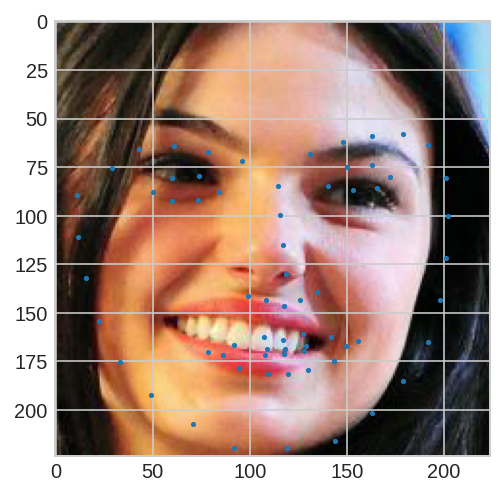

###DATA VISULISATION

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dfall, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = dfall.Landmarks
        self.Img_dir = dfall.Image
        self.transform = transform
        self.Exp = dfall.Expression
        self.Val = dfall.Valance
        self.Aro = dfall.Arosual

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Create a named colour
        red = [0,0,255]

        image = io.imread(dfall.Image[idx])
        landmarks = dfall.Landmarks[idx]
        landmarks= landmarks.astype(int)

        if (landmarks.any()) >224:
          landmarks=0

        image[landmarks[:, 0], landmarks[:, 1]]=red
        #landmarks = landmarks.astype('float')
        Expression = self.Exp[idx]
        Valance = self.Val[idx]
        Arosual =self.Aro[idx]

        sample = {'image': image,  'Expression': Expression, 'Valance': Valance, 'Arosual':Arosual}
#, 'landmarks': torch.tensor(landmarks)
        if self.transform:
            sample1 = self.transform(sample['image'],sample['landmarks'])


        return sample

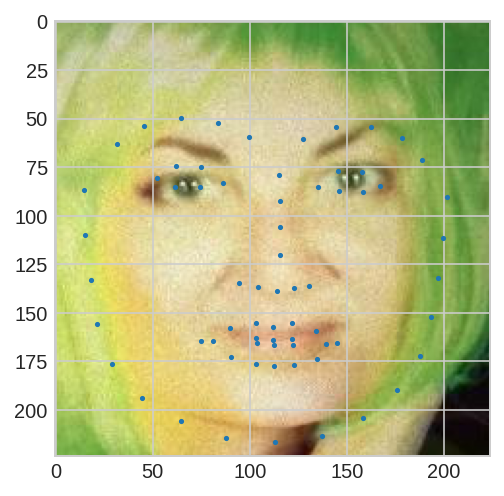

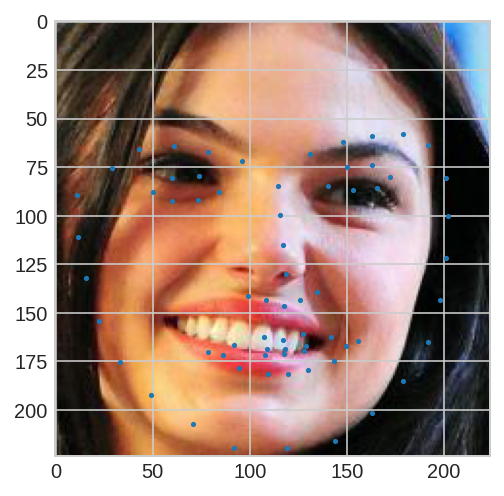

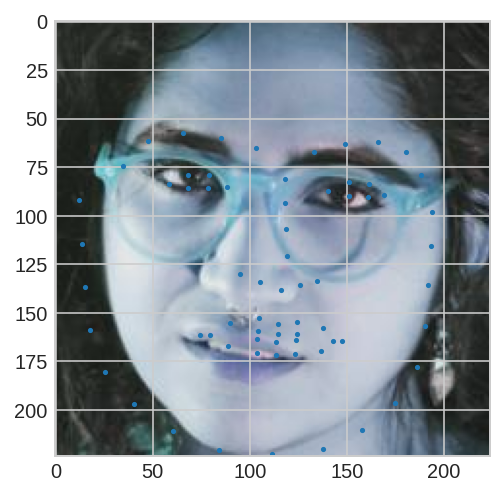

In [ ]:
landmarks_frame = dfall.Landmarks

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(dfall.Image[0]), dfall.Landmarks[0])
show_landmarks(io.imread(dfall.Image[1]), dfall.Landmarks[1])
show_landmarks(cv2.imread(dfall.Image[5]), dfall.Landmarks[5])
plt.show()

# XCEPTION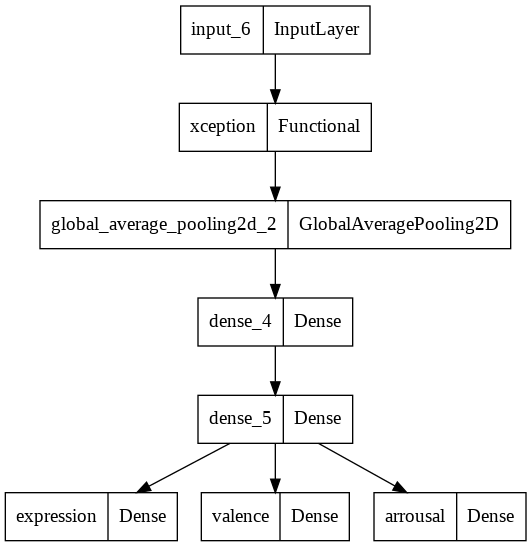

# XCEPTION NET

##Model Buliding

(None, 224, 224, 3) <dtype: 'float32'>
(None, 8) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
input_6 [(None, 224, 224, 3)] float32
xception (None, 224, 224, 3) float32
global_average_pooling2d_2 (None, 7, 7, 2048) float32
dense_4 (None, 2048) float32
dense_5 (None, 2048) float32
expression (None, 1024) float32
valence (None, 1024) float32
arrousal (None, 1024) float32
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_6[0][0]']  

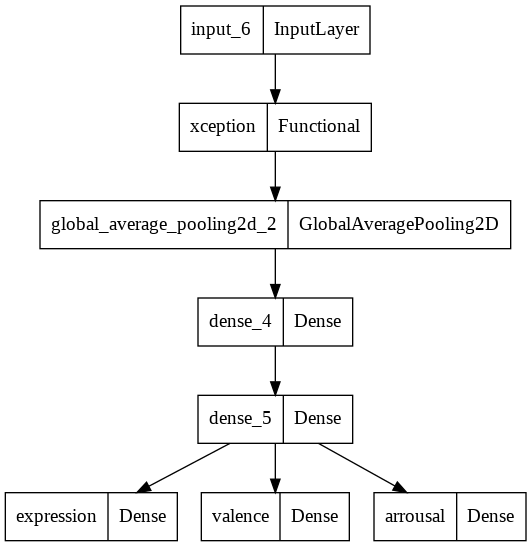

In [18]:
xception_base_model=Xception(weights="imagenet",
                             include_top=False,
                             input_shape =(224, 224,3))
class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]
        
    def create_model(self,
                    kernel_size = (3,3),
                    pool_size= (2,2),
                    first_filters = 32,
                    second_filters = 64,
                    third_filters = 128,
                    first_dense=256,
                    second_dense=128,
                    dropout_conv = 0.3,
                    dropout_dense = 0.3):
      visible = Input(shape=(224,224,3))
      x= xception_base_model(visible, training=True)
      flat = GlobalAveragePooling2D()(x)
      hidden1 = Dense(2048, activation='relu')(flat)
      hidden1 = Dense(1024, activation='relu')(hidden1)

      expression = Dense(8, name='expression')(hidden1)
      valence = Dense(1, activation='linear', name='valence')(hidden1)
      arrousal = Dense(1, activation='linear', name='arrousal')(hidden1)

      model = Model(inputs=visible, outputs=[expression,valence,arrousal])
      model.compile(optimizer=Adam(learning_rate=0.0001), 
                    loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError(), MeanSquaredError()], 
                    loss_weights={'expression': 5, 'valence': 0.25, 'arrousal':0.25},
                    metrics={'expression':'accuracy','expression':tfa.metrics.CohenKappa(num_classes=8,sparse_labels=True),'valence': 'RootMeanSquaredError', 'arrousal':'RootMeanSquaredError'})
      #,'expression':tfa.metrics.CohenKappa(num_classes=8,sparse_labels=True)
      [print(i.shape, i.dtype) for i in model.inputs]
      [print(o.shape, o.dtype) for o in model.outputs]
      [print(l.name, l.input_shape, l.dtype) for l in model.layers]

      return model
        
    
    def train(self, model, toy):
        """
        Train the model
        """
        if toy:
            epochs=10
            validation_steps=2
        else:
            epochs=45
            validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/face/best_model1.h5'
                                        #,monitor='val_acc'
                                        ,verbose=1
                                        #,save_best_only=True
                                        ,save_weights_only=True)
        # Train
        training = model.fit_generator(generator=self.generators.train_generator
                                ,epochs=epochs
                                #,steps_per_epoch=steps_per_epoch
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps
                                ,callbacks=[checkpointer])
                                #,callbacks=[earlystopper, checkpointer, reduce_lr])
        # Get the best saved weights
        model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/face/best_model1.h5')
        return training
   
# Create and train the model
trainer = ModelTrainer(generators)

model = trainer.create_model()
model.summary()
plot_model(model, to_file='convolutional_neural_network.png')

##Model Traning

In [14]:
training=trainer.train(model)
print("Trained")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/45
94/94 [==============================] - ETA: 0s - loss: 10.5439 - expression_loss: 2.0870 - valence_loss: 0.2355 - arrousal_loss: 0.2002 - expression_accuracy: 0.1210 - valence_root_mean_squared_error: 0.4853 - arrousal_root_mean_squared_error: 0.4474
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/face/best_model1.h5
94/94 [==============================] - 993s 10s/step - loss: 10.5439 - expression_loss: 2.0870 - valence_loss: 0.2355 - arrousal_loss: 0.2002 - expression_accuracy: 0.1210 - valence_root_mean_squared_error: 0.4853 - arrousal_root_mean_squared_error: 0.4474 - val_loss: 10.5275 - val_expression_loss: 2.0827 - val_valence_loss: 0.2701 - val_arrousal_loss: 0.1855 - val_expression_accuracy: 0.1187 - val_valence_root_mean_squared_error: 0.5197 - val_arrousal_root_mean_squared_error: 0.4306
Epoch 2/45
94/94 [==============================] - ETA: 0s - loss: 10.5106 - expression_loss: 2.0807 - valence_loss: 0.2366 - arrousal_loss: 0.1925 - expressio

In [19]:
training=trainer.train(model, toy)
print("Trained")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 10.5332 - expression_loss: 2.0850 - valence_loss: 0.2316 - arrousal_loss: 0.2017 - expression_cohen_kappa: 0.0043 - valence_root_mean_squared_error: 0.4813 - arrousal_root_mean_squared_error: 0.4491
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/face/best_model1.h5
94/94 [==============================] - 167s 2s/step - loss: 10.5332 - expression_loss: 2.0850 - valence_loss: 0.2316 - arrousal_loss: 0.2017 - expression_cohen_kappa: 0.0043 - valence_root_mean_squared_error: 0.4813 - arrousal_root_mean_squared_error: 0.4491 - val_loss: 10.5116 - val_expression_loss: 2.0799 - val_valence_loss: 0.2400 - val_arrousal_loss: 0.2090 - val_expression_cohen_kappa: -0.0037 - val_valence_root_mean_squared_error: 0.4899 - val_arrousal_root_mean_squared_error: 0.4572
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 10.4982 - expression_loss: 2.0799 - valence_loss: 0.2238 - arrousal_loss: 0.1716 - 

## Model Analysis



In [20]:
expression, valance, arosual = model.predict_generator(generators.train_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


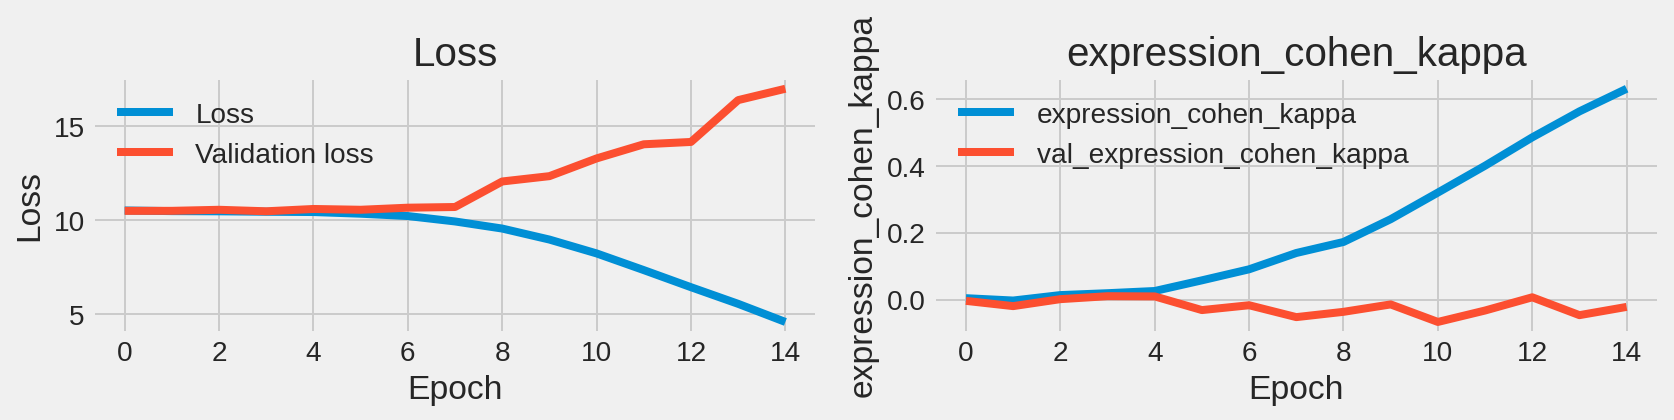

              precision    recall  f1-score   support

         0.0       0.06      0.08      0.07        12
         1.0       0.07      0.05      0.06        20
         2.0       0.37      0.30      0.33        23
         3.0       0.14      0.09      0.11        23
         4.0       0.15      0.41      0.22        17
         5.0       0.20      0.14      0.16        22
         6.0       0.16      0.16      0.16        19
         7.0       0.12      0.08      0.10        24

    accuracy                           0.16       160
   macro avg       0.16      0.16      0.15       160
weighted avg       0.17      0.16      0.16       160



In [22]:
class Evaluator:
    """
    Evaluaion :predict on test data (not submission data from test folder)
    and print reports, plot results etc.
    """
     
    def __init__(self, model, training, generator, y_true):
        self.training = training
        self.generator = generator
        # predict the data
        steps=5
        self.expression, self.valance, self.arosual = model.predict_generator(self.generator, steps=steps)
        self.y_pred = np.argmax(self.expression, axis=1)
        self.y_true=y_true[:len(self.y_pred)]        
    """
    Accuracy, evaluation
    """
    def plot_history(self):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(12,3))
        ax[0].plot(self.training.history['loss'], label="Loss")
        ax[0].plot(self.training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(self.training.history['expression_cohen_kappa'], label="expression_cohen_kappa")
        ax[1].plot(self.training.history['val_expression_cohen_kappa'], label="val_expression_cohen_kappa ")
        ax[1].set_title('expression_cohen_kappa')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('expression_cohen_kappa')
        ax[1].legend()
        plt.tight_layout()
        plt.show()
    
    """def plot_roc(self):
        #y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
        # Calculate roc
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_true, self.y_pred)
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()"""
        
    def print_report(self):
        """
        Predict and evaluate using ground truth from labels
        Test generator did not shuffle 
        and we can use true labels for comparison
        """
        #Print classification report
        print(metrics.classification_report(self.y_true, self.y_pred))

# Create evaluator instance
evaluator = Evaluator(model, training, generators.val_generator, dfall['Expression'])

# Draw accuracy and loss charts
evaluator.plot_history()

# ROC curve
#evaluator.plot_roc()

# Classification report
evaluator.print_report()

# MOBILENETV3 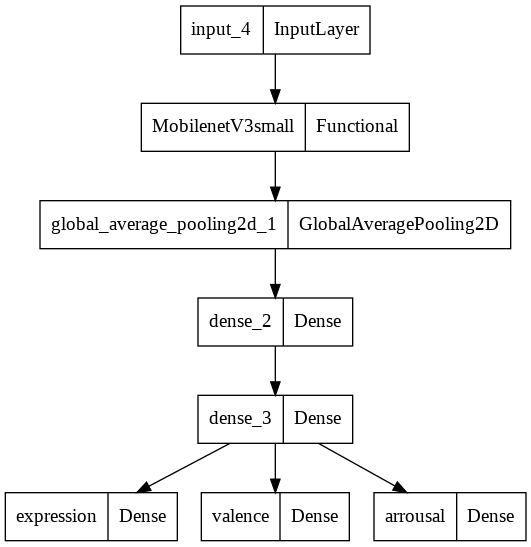

# MOBILENET V3

##MODEL BUILD

(None, 224, 224, 3) <dtype: 'float32'>
(None, 8) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
input_4 [(None, 224, 224, 3)] float32
MobilenetV3small (None, 224, 224, 3) float32
global_average_pooling2d_1 (None, 7, 7, 576) float32
dense_2 (None, 576) float32
dense_3 (None, 2048) float32
expression (None, 1024) float32
valence (None, 1024) float32
arrousal (None, 1024) float32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 7, 7, 576)    939120      ['input_4[0][

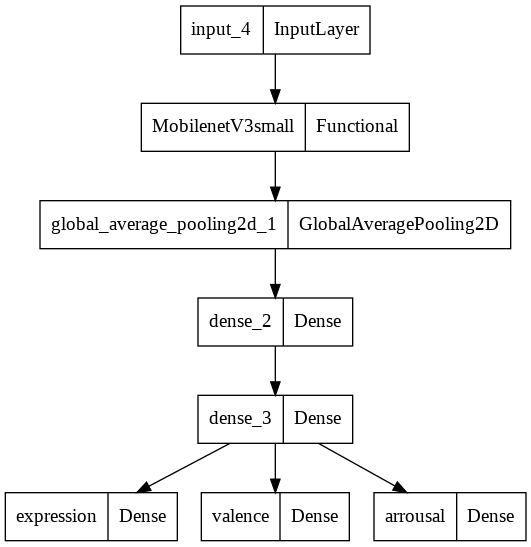

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224,3),
                                               include_top=False,
                                               weights='imagenet')

class ModelTrainer:
    """
    Create and fit the model
    """
    
    def __init__(self, generators):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]
        
    def create_model(self,
                    kernel_size = (3,3),
                    pool_size= (2,2),
                    first_filters = 32,
                    second_filters = 64,
                    third_filters = 128,
                    first_dense=256,
                    second_dense=128,
                    dropout_conv = 0.3,
                    dropout_dense = 0.3):
      visible = Input(shape=(224,224,3))
      x= base_model(visible, training=True)
      flat = GlobalAveragePooling2D()(x)
      hidden1 = Dense(2048, activation='relu')(flat)
      hidden1 = Dense(1024, activation='relu')(hidden1)

      expression = Dense(8, name='expression')(hidden1)
      valence = Dense(1, activation='linear', name='valence')(hidden1)
      arrousal = Dense(1, activation='linear', name='arrousal')(hidden1)

      model = Model(inputs=visible, outputs=[expression,valence,arrousal])
      model.compile(optimizer=Adam(learning_rate=0.0001), 
                    loss=[SparseCategoricalCrossentropy(from_logits=True), MeanSquaredError(), MeanSquaredError()], 
                    loss_weights={'expression': 5, 'valence': 0.25, 'arrousal':0.25},
                    metrics={'expression':'accuracy','expression':tfa.metrics.CohenKappa(num_classes=8,sparse_labels=True),'valence': 'RootMeanSquaredError', 'arrousal':'RootMeanSquaredError'})
      #,'expression':tfa.metrics.CohenKappa(num_classes=8,sparse_labels=True)
      [print(i.shape, i.dtype) for i in model.inputs]
      [print(o.shape, o.dtype) for o in model.outputs]
      [print(l.name, l.input_shape, l.dtype) for l in model.layers]

      return model
        
    
    def train(self, model, toy):
        """
        Train the model
        """
        if toy:
            epochs=10
            #steps_per_epoch=20
            validation_steps=2
        else:
            epochs=25
            #steps_per_epoch=100
            #steps_per_epoch=30
            #steps_per_epoch=10
            validation_steps=5
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
        # Save the best model during the traning
        checkpointer = ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/face/best_modelmobilenetv3.h5'
                                        #,monitor='val_acc'
                                        ,verbose=1
                                        #,save_best_only=True
                                        ,save_weights_only=True)
        # Train
        training = model.fit_generator(generator=self.generators.train_generator
                                ,epochs=epochs
                                #,steps_per_epoch=steps_per_epoch
                                ,validation_data=self.generators.val_generator
                                ,validation_steps=validation_steps
                                ,callbacks=[checkpointer])
                                #,callbacks=[earlystopper, checkpointer, reduce_lr])
        # Get the best saved weights
        model.load_weights('/content/gdrive/MyDrive/Colab Notebooks/face/best_modelmobilenetv3.h5')
        return training
   
# Create and train the model
trainer = ModelTrainer(generators)

model = trainer.create_model(kernel_size = (3,3),
                    pool_size= (2,2),
                    first_filters = 128,
                    second_filters = 256,
                    third_filters = 512,
                    first_dense=256,
                    second_dense=128,
                    dropout_conv = 0.3,
                    dropout_dense = 0.2)
model.summary()
plot_model(model, to_file='convolutional_neural_network.png')

##MODEL TRAIN

In [ ]:
training=trainer.train(model, toy)
print("Trained")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/45
94/94 [==============================] - ETA: 0s - loss: 10.7857 - expression_loss: 2.1360 - valence_loss: 0.2472 - arrousal_loss: 0.1750 - expression_accuracy: 0.1207 - valence_root_mean_squared_error: 0.4972 - arrousal_root_mean_squared_error: 0.4183
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/face/best_modelmobilenetv3.h5
94/94 [==============================] - 773s 8s/step - loss: 10.7857 - expression_loss: 2.1360 - valence_loss: 0.2472 - arrousal_loss: 0.1750 - expression_accuracy: 0.1207 - valence_root_mean_squared_error: 0.4972 - arrousal_root_mean_squared_error: 0.4183 - val_loss: 10.5453 - val_expression_loss: 2.0887 - val_valence_loss: 0.2518 - val_arrousal_loss: 0.1549 - val_expression_accuracy: 0.1375 - val_valence_root_mean_squared_error: 0.5018 - val_arrousal_root_mean_squared_error: 0.3936
Epoch 2/45
94/94 [==============================] - ETA: 0s - loss: 10.5003 - expression_loss: 2.0809 - valence_loss: 0.2257 - arrousal_loss: 0.1570 - 

In [ ]:
training=trainer.train(model, toy)
print("Trained")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
94/94 [==============================] - ETA: 0s - loss: 10.7092 - expression_loss: 2.1217 - valence_loss: 0.2403 - arrousal_loss: 0.1635 - expression_cohen_kappa: 0.0030 - valence_root_mean_squared_error: 0.4902 - arrousal_root_mean_squared_error: 0.4043
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/face/best_modelmobilenetv3.h5
94/94 [==============================] - 931s 10s/step - loss: 10.7092 - expression_loss: 2.1217 - valence_loss: 0.2403 - arrousal_loss: 0.1635 - expression_cohen_kappa: 0.0030 - valence_root_mean_squared_error: 0.4902 - arrousal_root_mean_squared_error: 0.4043 - val_loss: 10.6811 - val_expression_loss: 2.1152 - val_valence_loss: 0.2503 - val_arrousal_loss: 0.1707 - val_expression_cohen_kappa: -0.0111 - val_valence_root_mean_squared_error: 0.5003 - val_arrousal_root_mean_squared_error: 0.4132
Epoch 2/25
94/94 [==============================] - ETA: 0s - loss: 10.4757 - expression_loss: 2.0763 - valence_loss: 0.2253 - arrousal_loss

## MODEL ANALYSIS

In [ ]:
expression, valance, arosual = model.predict_generator(generators.test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


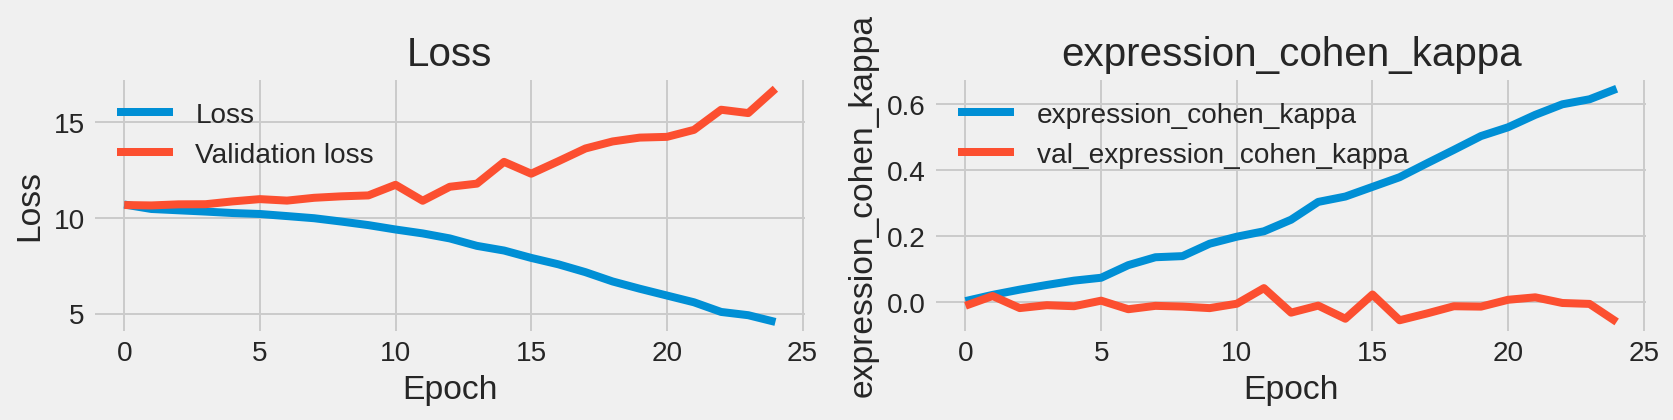

              precision    recall  f1-score   support

         0.0       0.14      0.25      0.18        12
         1.0       0.00      0.00      0.00        20
         2.0       0.08      0.13      0.10        23
         3.0       0.25      0.13      0.17        23
         4.0       0.00      0.00      0.00        17
         5.0       0.11      0.09      0.10        22
         6.0       0.17      0.16      0.16        19
         7.0       0.17      0.21      0.19        24

    accuracy                           0.12       160
   macro avg       0.11      0.12      0.11       160
weighted avg       0.12      0.12      0.11       160



In [ ]:
class Evaluator:
    """
    Evaluaion :predict on test data (not submission data from test folder)
    and print reports, plot results etc.
    """
     
    def __init__(self, model, training, generator, y_true):
        self.training = training
        self.generator = generator
        # predict the data
        steps=5
        self.expression, self.valance, self.arosual = model.predict_generator(self.generator, steps=steps)
        self.y_pred = np.argmax(self.expression, axis=1)
        self.y_true=y_true[:len(self.y_pred)]        
    """
    Accuracy, evaluation
    """
    def plot_history(self):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(12,3))
        ax[0].plot(self.training.history['loss'], label="Loss")
        ax[0].plot(self.training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(self.training.history['expression_cohen_kappa'], label="expression_cohen_kappa")
        ax[1].plot(self.training.history['val_expression_cohen_kappa'], label="val_expression_cohen_kappa ")
        ax[1].set_title('expression_cohen_kappa')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('expression_cohen_kappa')
        ax[1].legend()
        plt.tight_layout()
        plt.show()
    
    """def plot_roc(self):
        #y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
        # Calculate roc
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_true, self.y_pred)
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()"""
        
    def print_report(self):
        """
        Predict and evaluate using ground truth from labels
        Test generator did not shuffle 
        and we can use true labels for comparison
        """
        #Print classification report
        print(metrics.classification_report(self.y_true, self.y_pred))

# Create evaluator instance
evaluator = Evaluator(model, training, generators.val_generator, dfall['Expression'])

# Draw accuracy and loss charts
evaluator.plot_history()

# ROC curve
#evaluator.plot_roc()

# Classification report
evaluator.print_report()

#PYTORCH EXTRAS

In [ ]:
from google.colab.patches import cv2_imshow
face_dataset = FaceLandmarksDataset(dfall)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape)#, sample['landmarks'].shape)
"""
    ax = plt.subplot(1, 137, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    #print(sample['landmarks'])
    #show_landmarks(sample['image'],sample['landmarks'])
    plt.imshow(sample['image'])
    #plt.scatter(sample['landmarks'][:, 0], sample['landmarks'][:, 1], s=10, marker='.')

    if i == 137:
        plt.show()
        break"""

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
validation_split = .2
shuffle_dataset = True
random_seed= 10

# Creating data indices for training and validation splits:
dataset_size = len(face_dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(face_dataset,  batch_size=32,
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(face_dataset, batch_size=32,
                                                sampler=valid_sampler, num_workers=4)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(224, 3, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU())#,
            #nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU())#,
            #nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU())#,
            #nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU())#,
            #nn.MaxPool2d(2))       
        self.layer5 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU())#,
            #nn.MaxPool2d(2))
        
        # Dropout to avoid overfitting
        self.drop_out = nn.Dropout()

        # Fully connected layers
        self.fc1 = nn.Linear(3, 256)
        self.fc2 = nn.Linear(256, 6)
        self.regression1 =nn.Linear(256,1)
        self.regression2 =nn.Linear(256,1)
        
    def forward(self, x):
        x=x
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        # Flatten

        out = self.drop_out(out)
        out = self.fc1(out)
        out1 = self.fc2(out)
        out2 = self.regression1(out)
        out3 =  self.regression2(out)
        return out1,out2,out3

In [ ]:
# Declaring the loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN()
model = model.to(device)
print(model)

#Loss Function
loss_fn = {torch.nn.CrossEntropyLoss(),torch.nn.MSELoss(),torch.nn.MSELoss() }
              

#optimizer and learning rate
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);

CNN(
  (layer1): Sequential(
    (0): Conv2d(224, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (regression1): Linear(in_features=256, out_features=1, bias=True)
  (regression2): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
train_data_path = '/content/gdrive/MyDrive/Colab Notebooks/face/img' 
classes_path= '/content/gdrive/MyDrive/Colab Notebooks/face/annota'
train_image_paths = [] #to store image paths in list
classes = [] #to store class values
def flatten(t):
    return [item for sublist in t for item in sublist]
#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path+ '/*'):
  for cls_pth in glob.glob(classes_path+'/*'):
    classes.append(classes_path+ '/')
  train_image_paths.append(data_path)
print('train_image_path example: ', train_image_paths)

#2.
# split train valid from train paths (80,20)
train_image_paths
print("Train size: {}".format(len(train_image_paths)))



train_image_path example:  ['/content/gdrive/MyDrive/Colab Notebooks/face/img/3.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/2.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/7.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/1.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/10.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/0.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/5.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/38.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/48.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/16.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/18.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/43.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/15.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/36.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/44.jpg', '/content/gdrive/MyDrive/Colab Notebooks/face/img/23.jpg', '/content/gdrive/MyDrive/Colab Not

In [ ]:
#######################################################
#               Define Dataset Class
#######################################################
from torchvision.transforms.transforms import ToTensor
mean = [0.5, 0.49, 0.52]
std =[0.5, 0.48, 0.53]

train_transform =transforms.Compose([
                                     transforms.Resize((128,128)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))])

class FEdataset(Dataset):
    def __init__(self, image_paths, df, transform=False):
        self.image_paths = image_paths
        self.df= df
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        if image is None:
          print('None')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label1 = df.Expression
        label2 = df.Valence
        label3 = df.Arosual
        
        return image, label1, label2, label3
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = FEdataset(train_image_paths,df,train_transform)
#valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
#test_dataset = LandmarkDataset(test_image_paths,test_transforms)

6 -0.34127 0.831839
6 0.547918 0.547619
1 0.153401 0.00431332
1 -0.0172533 -0.0555556
1 0.174603 0.0388903
0 -0.488145 0.00793651
0 0.785714 0.249054
0 0 0.183895
1 0.495154 -0.229129
1 0.00498107 0.015873


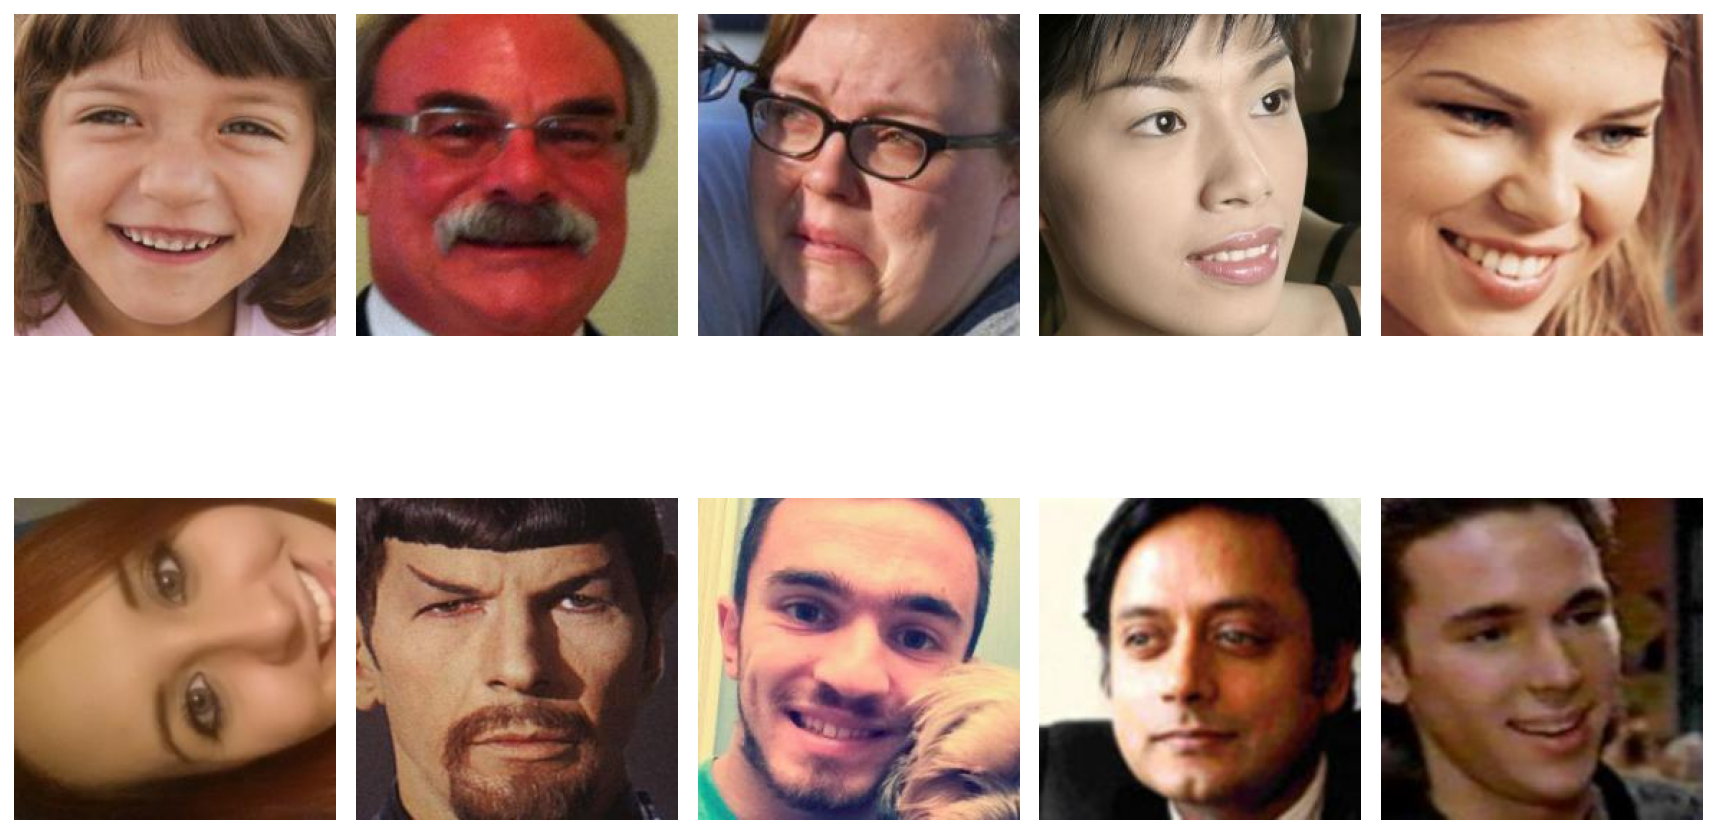

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    #we remove the normalize and tensor conversion from our augmentation pipeline
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, exp, aro, val = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        print(exp[0][i], aro[0][i], val[0][i])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [ ]:
from tqdm.notebook import tqdm
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_CLASSES = 10
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    multi_acc
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for i in range(len(face_dataset)):
      sample = face_dataset[i]
      input1=torch.Tensor(sample['image'])
      input1 = input1[None, :]
      output1,output2,output3=sample['Expression'],sample['Valance'],sample['Arosual']
      optimizer.zero_grad()
      print(input1.shape)
      y_train_pred1,y_train_pred2,y_train_pred3 = model(input1)
      train_loss = loss_fn((y_train_pred1,y_train_pred2,y_train_pred3),(output1,output2,output3))
      train_acc = multi_acc((y_train_pred1,y_train_pred2,y_train_pred3),(output1,output2,output3))
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} ')
    for X_train_batch, X_train2, y_train_batch1,y_train_batch2,y_train_batch3 in face_dataset:
       # X_train_batch, y_train_batch1,y_train_batch2,y_train_batch3 = X_train_batch.to(device), y_train_batch1.to(device), y_train_batch2.to(device), y_train_batch3.to(device)
        optimizer.zero_grad()
        X_train_batch=torch.cat((X_train_batch, X_train2), 0)
        X_train_batch.size()
        y_train_pred1,y_train_pred2,y_train_pred3 = model(X_train_batch,X_train2)
        
        train_loss = loss_fn((y_train_pred1,y_train_pred2,y_train_pred3),(y_train_batch1,y_train_batch2,y_train_batch3))
        train_acc = multi_acc((y_train_pred1,y_train_pred2,y_train_pred3),(y_train_batch1,y_train_batch2,y_train_batch3))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
   
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} ')

Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 224, 224, 3])


TypeError: ignored